In [71]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from __future__ import print_function
from keras.preprocessing.image import load_img, img_to_array

from keras.applications import vgg19

# Set backend as tensorflow
from keras import backend as K
K.set_image_dim_ordering("tf")

%matplotlib inline

In [72]:
import h5py

f = h5py.File("vgg19_weights_tf_dim_ordering_tf_kernels.h5", "r")
print(f.keys())

[u'block1_conv1', u'block1_conv2', u'block1_pool', u'block2_conv1', u'block2_conv2', u'block2_pool', u'block3_conv1', u'block3_conv2', u'block3_conv3', u'block3_conv4', u'block3_pool', u'block4_conv1', u'block4_conv2', u'block4_conv3', u'block4_conv4', u'block4_pool', u'block5_conv1', u'block5_conv2', u'block5_conv3', u'block5_conv4', u'block5_pool', u'fc1', u'fc2', u'flatten', u'predictions']


In [73]:
model = vgg19.VGG19(weights=None)
# model.load_weights("vgg19_weights_tf_dim_ordering_tf_kernels.h5")

In [74]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block1_conv2', 0.2),
    ('block2_conv1', 0.2),
    ('block2_conv2', 0.2),
    ('block3_conv1', 0.2),
    ('block3_conv2', 0.2),
    ('block3_conv3', 0.2),
    ('block3_conv4', 0.2),
    ('block4_conv1', 0.2),
    ('block4_conv2', 0.2),
    ('block4_conv3', 0.2),
    ('block4_conv4', 0.2),
    ('block5_conv1', 0.2),
    ('block5_conv2', 0.2),
    ('block5_conv3', 0.2),
    ('block5_conv4', 0.2)]

In [75]:
class CONFIG:
    IMAGE_WIDTH = 400
    IMAGE_HEIGHT = 300
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

In [76]:
def reshape_and_normalize_image(image):
    """
    Reshape and normalize the input image (content or style)
    """
    
    # Reshape image to mach expected input of VGG16
    image = np.reshape(image, ((1,) + image.shape))
    
    # Substract the mean to match the expected input of VGG16
    image = image - CONFIG.MEANS
    
    return image

<tf.Variable 'Variable_4:0' shape=(1, 300, 400, 3) dtype=float32_ref>


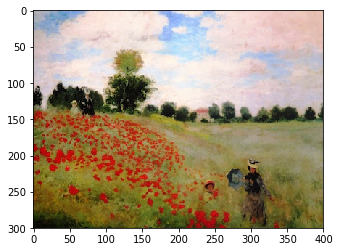

In [88]:
content_image_path = "./images/monet.jpg"

image = plt.imread(content_image_path)
plt.imshow(image)

content_image = reshape_and_normalize_image(image)
content_image = K.variable(content_image)

print(content_image)

<tf.Variable 'Variable_2:0' shape=(1, 300, 400, 3) dtype=float32_ref>


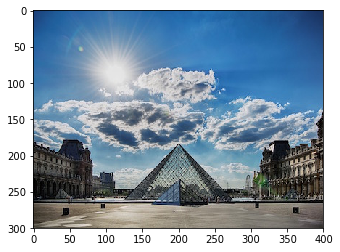

In [86]:
style_image_path = "./images/louvre_small.jpg"

image = plt.imread(style_image_path)
plt.imshow(image)

style_image = reshape_and_normalize_image(image)
style_image = K.variable(style_image)

print(style_image)

In [91]:
generated_image = K.placeholder((1, img_nrows, img_ncols, 3))

print(generated_image.get_shape())

(1, 300, 400, 3)


In [94]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([content_image,
                              style_image,
                              generated_image], axis=0)

print(input_tensor.shape)

(3, 300, 400, 3)
